### Imports

In [1]:
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, r2_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, chi2

# to determine the p-values with anova
from sklearn.feature_selection import f_classif, f_regression

# to select features
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, RFE # Recursive Feature Elimination

from feature_engine.selection import DropDuplicateFeatures, DropConstantFeatures, SmartCorrelatedSelection, SelectByShuffling, RecursiveFeatureElimination
from feature_engine.datetime import DatetimeFeatures
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

from ta import add_all_ta_features
from ta.utils import dropna

from xgboost import XGBClassifier, XGBRegressor

import pandas_market_calendars as mcal
import warnings
import statistics

\\VSYS-P-GW01.cloud.vsys.ca\RDFolderRedirect$\fanjum_cwp\Desktop\Python\2x4\venv\Lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Reading Data from Excel daily_dataframe_main

In [2]:
# Takes 1 min 40 secs to run
Variables = pd.read_excel('daily_dataframe_main.xlsx', header=[0,1], sheet_name='Variables',index_col=0)
Response = pd.read_excel('daily_dataframe_main.xlsx',sheet_name= 'Response' ,index_col=0)

# Just using Unadjusted data for now
# Response = Response[['LB_Close','Close_ret','Close_Up_Down']]

### Imputing Values
<div style="color: DarkBlue; font-size:22px;" class="alert alert-block alert-warning"> 
<b>Check:</b> Backfilling and then frontfilling Variables DataFrame, and filling zeros with Median? - Check if it makes sense
</div>


In [3]:
Variables.fillna(method='bfill', inplace=True)
# Variables.fillna(method='ffill', inplace=True)
# Replacing 0 with Median Values
# Variables.replace(to_replace=0, method='bfill', inplace=True) 
# Variables.replace(to_replace=0, method=Variables.median(), inplace=True) 

### Date Engineering

In [4]:
warnings.filterwarnings("ignore")

Variables['day'] = Variables.index.day
Variables['month'] = Variables.index.month
Variables['year'] = Variables.index.year
Variables['weekday'] = Variables.index.weekday
Variables['week'] = Variables.index.week
Variables['weekofyear'] = Variables.index.weekofyear
Variables['quarter'] = Variables.index.quarter
Variables['dayofyear'] = Variables.index.dayofyear
Variables['dayofweek'] = Variables.index.dayofweek
Variables['is_month_end'] = Variables.index.is_month_end
Variables['is_month_start'] = Variables.index.is_month_start
Variables['is_quarter_end'] = Variables.index.is_quarter_end
Variables['is_quarter_start'] = Variables.index.is_quarter_start
Variables['is_year_end'] = Variables.index.is_year_end
Variables['is_year_start'] = Variables.index.is_year_start
Variables['is_leap_year'] = Variables.index.is_leap_year


### Adding Technical Indicators

In [5]:
warnings.filterwarnings("ignore")

# TA_df = Variables[['LumberOHLCV LBHigh','LumberOHLCV LBLow','LumberOHLCV LBClose','LumberOHLCV LBVolume','LumberOHLCV LBopenInterest']]
TA_df = Variables.loc[:,('Lumber_OHLCV',)][['LB_High','LB_Low','LB_Close','LB_Volume','LB_openInterest']]

TA_df.columns = ['High','Low','Close','Volume','OpenInterest']
TA_df['Open'] = TA_df['Close'].shift(-1)

# TA_df['weekday'] = Variables.index.weekday
# TA_df = TA_df[~TA_df.weekday.isin([5,6])]
# TA_df = TA_df.drop(['weekday'],axis=1)

TA_df = dropna(TA_df)
TA_df.sort_index(ascending=True, inplace=True)
TA_df = add_all_ta_features(TA_df, open="Open", high="High", low="Low", close="Close", volume="Volume")
TA_df.sort_index(ascending=False, inplace=True)
TA_df.drop(['Open','High','Low','Close','Volume','OpenInterest'],axis=1,inplace=True)
TA_df.columns = [str('TA_') + TA_df.columns]
TA_df = TA_df.replace([np.inf, -np.inf], np.nan).fillna(TA_df.mean())
Variables = pd.concat([Variables,TA_df], axis=1)

### Replacing punctuation strings in column names

In [6]:
cols = [str(w).translate(str.maketrans('', '', string.punctuation)).lstrip().rstrip() for w in Variables.columns]
Variables.columns = cols

### Find Last Available Date for each Variable in the DataFrame

In [7]:
last_valid_loc = pd.DataFrame(data=Variables.apply(lambda col: col.last_valid_index()), columns = ['End_Dt'])
last_valid_loc.sort_values(by='End_Dt', ascending=False ,inplace=True)
# last_valid_loc = last_valid_loc[last_valid_loc.End_Dt.notna()]
last_valid_loc

,End_Dt
LumberOHLCV LBHigh,2022-06-29
CFTClegacy ChangeinNoncommercialLongAll,2022-06-29
CFTClegacy NoncommercialPositionsShortOther,2022-06-29
CFTClegacy NoncommercialPositionsSpreadingOther,2022-06-29
CFTClegacy CommercialPositionsLongOther,2022-06-29
...,...
LumberTracknorthamericanproduction TotalNorthAmerica,NaT
LumberTracknorthamericanshipment PrairiesAndEasternCanada,NaT
LumberTracknorthamericanshipment TotalNorthAmerica,NaT
CFTClegacy TotalReportablePositionsLongAll,NaT


<div style="color: DarkBlue; font-size:22px;" class="alert alert-block alert-warning"> 
<b>To Do:</b> For now using custom based method - but change it eventually with Feature-engine etc. Check which method makes more sense
</div>

In [8]:
# Takes 35 secounds to run
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.
        Columns of dtype object are imputed with the most frequent value in column.
        Columns of other types are imputed with median of column.
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
        
Variables = DataFrameImputer().fit_transform(Variables)


### Trading Days and after 2011
<div style="color: Red; font-size:22px;" class="alert alert-block alert-warning">  Restricting the dataset since 2011 only trading days for cme agriculture - ideally should be for CME Lumber!!
<div style="color: Green; font-size:22px;" class="alert alert-block alert-warning"> 
<b>To Do:</b> Issues is we have some forward fills which doesn't represent data correctly
</div>

In [9]:
Variables.sort_index(ascending = False, inplace = True)
Response.sort_index(ascending = False, inplace = True)

cme = mcal.get_calendar("CME_Agriculture")
cme_trading_days = cme.schedule(start_date=Variables.index[-1].date(), end_date=Variables.index[0].date()).index
cme_trading_days = cme_trading_days.sort_values(ascending=False)
cme_trading_days = pd.DatetimeIndex(cme_trading_days)

Variables = Variables[Variables.index > '2011-01-01']
Variables = Variables[Variables.index.isin(cme_trading_days)]


Response = Response[Response.index > '2011-01-01']
Response = Response[Response.index.isin(cme_trading_days)]
# Response = Response[(Response.Close_Up_Down == 1) | (Response.Close_Up_Down == -1)]

Variables.index = pd.DatetimeIndex(Variables.index)
Response.index = pd.DatetimeIndex(Response.index)
Variables = Variables.reindex(Response.index)

len(Variables), len(Response)


(2895, 2895)

### MultiClassification Targets 

Labels
 2        915
-2        894
 1        383
-1        365
 0        338
dtype: int64

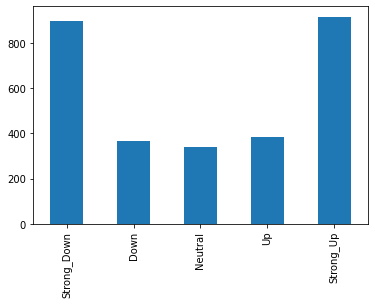

In [10]:
pv_1 = 0.005 # higher and lower than 0.5% return
pv_2 = 0.02 # higher and lower than 2% return

col = 'Close_ret' # Can also be 'Adj_close_ret'
mutli_class_buckets = Response[col].value_counts(bins = [Response[col].min(),-pv_2, -pv_1,pv_1, pv_2,Response[col].max()])
mutli_class_buckets.sort_index(ascending=True, inplace=True)
mutli_class_buckets.index = ['Strong_Down','Down','Neutral','Up','Strong_Up']
mutli_class_buckets.plot(kind='bar');

Neutral = ((Response[col] > -pv_1) & (Response[col] < pv_1))
Down = ((Response[col] > -pv_2) & (Response[col] < -pv_1))
Up = ((Response[col] > pv_1) & (Response[col] < pv_2))
Strong_Down = (Response[col] < -pv_2) 
Strong_Up = (Response[col] > pv_2)

conditions = [Strong_Down, Down, Neutral, Up, Strong_Up]
choices = [-2, -1, 0, 1, 2]
multi_class = np.select(conditions, choices, default=0)

Target = pd.DataFrame(index = Response.index, data = multi_class)
Target.columns = ['Labels']
Response['Labels'] = Target.Labels.values
Target.value_counts()


    -- Choose Response Variable here - LB_Close, Close_ret, Close_Up_Down, OR Adjusted Data from above

### Remove Variables with all NaNs
<div style="color: Green; font-size:22px;" class="alert alert-block alert-warning"> 
<b>To Do:</b> Check why these variables have NaNs
</div>


In [11]:
Variables_with_nans = set(Variables.columns) - set(Variables.drop(Variables.columns[Variables.isna().all()].to_list(), axis=1).columns)
Variables_with_nans

{'CFTClegacy ConcentrationGrossLT4TDRShortOl',
 'CFTClegacy TotalReportablePositionsLongAll',
 'LumberTracklumberexportus TotalLumberExports',
 'LumberTracknorthamericanproduction PrairiesAndEasternCanada',
 'LumberTracknorthamericanproduction TotalNorthAmerica',
 'LumberTracknorthamericanshipment PrairiesAndEasternCanada',
 'LumberTracknorthamericanshipment TotalNorthAmerica'}

In [12]:
Variables.drop(Variables.columns[Variables.isna().all()].to_list(), axis=1, inplace=True)
Variables.drop(Variables.columns[Variables.isnull().all()].to_list(), axis=1, inplace=True)
print(pd.Series(Variables.dtypes.values).value_counts())
print("Total Variables Left:",pd.Series(Variables.dtypes.values).value_counts().sum())


float64    744
int64       11
bool         7
dtype: int64
Total Variables Left: 762


In [13]:
Response.drop(Response.columns[Response.isna().all()].to_list(), axis=1, inplace=True)
Response.drop(Response.columns[Response.isnull().all()].to_list(), axis=1, inplace=True)
pd.Series(Response.dtypes.values).value_counts()

float64    6
int32      1
dtype: int64

### Change Bool cols (mostly date columns such as Is_year_end etc.) to int columns

In [14]:
list_of_bool_cols = Variables.columns[Variables.dtypes.values == 'bool'].to_list()
list_of_bool_cols_response = Response.columns[Response.dtypes.values == 'bool'].to_list()

for col in list_of_bool_cols:
    Variables[col] = Variables[col].astype(int)

for col in list_of_bool_cols_response:
    Response[col] = Response[col].astype(int)


### Helper Function

In [15]:
def fill_with_dataset(new_dataset,original_dataset):
    X_train_dict[new_dataset] = X_train_dict[original_dataset]
    X_test_dict[new_dataset] = X_test_dict[original_dataset]
    X_val_dict[new_dataset] = X_val_dict[original_dataset]

In [16]:
def add_to_features_df(model,dataset):
    model_name = type(model).__name__
    features_df.loc[(model_name, dataset),'Num_Features'] = len(X_train_dict[dataset].columns) # so can store list of features
    features_df.loc[(model_name, dataset),'Features_List'] = X_train_dict[dataset].columns.to_list()

    original_list = set(features_df.loc[(model_name, 'Original'),'Features_List'])
    dataset_list = set(features_df.loc[(model_name, dataset),'Features_List'])
    removed_list = list(sorted(original_list - dataset_list))
    
    features_df.loc[(model_name, dataset),'Removed_Features'] = removed_list
    features_df.loc[(model_name, dataset),'Model_Details'] = model
    

In [17]:
def get_shapes(dataset):
    print("\nShapes for dataset:",dataset)
    print("X_train Shape",X_train_dict[dataset].shape)
    print("X_test Shape",X_test_dict[dataset].shape)
    print("X_val Shape",X_val_dict[dataset].shape)
    # print("y_train Shape",y_train.shape)
    # print("y_test Shape",y_test.shape)
    # print("y_val Shape",y_val.shape)

In [18]:
def print_pipe_removed(pipe):
    total_removed = 0
    print("\nRemoved Features for Pipeline:",pipe)
    for i in range(len(pipe.steps)):
        step_name = pipe.steps[i][0]
        total_removed += len(pipe.named_steps[step_name].features_to_drop_)
        print(step_name, ":",len(pipe.named_steps[step_name].features_to_drop_))
    print("Total removed:",total_removed)

In [19]:
def remove_features(dataset,pipe):
    print("\nRemoving Features for dataset:",dataset)
    print("# Features before:",len(X_train_dict[dataset].columns.to_list()))
    X_train_dict[dataset] = pipe.transform(X_train_dict[dataset])
    X_test_dict[dataset] = pipe.transform(X_test_dict[dataset])
    X_val_dict[dataset] = pipe.transform(X_val_dict[dataset])

### Blocked cross-validation
https://goldinlocks.github.io/Time-Series-Cross-Validation/

In [20]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

btscv = BlockingTimeSeriesSplit(n_splits=5)

*****Change between Labels & Close_Up_Down columns for y_combined to make it either a Multiclass (5) or (3)***

In [21]:
# **cross_val_score - accuracy_score**                                                      
# scoring https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules

def add_metrics(model,dataset):
# Took mins to run
# Also put 'roc_auc' in metrics_list

    model_name = type(model).__name__
    metrics_list = ['balanced_accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted']

    # X_combined = pd.concat([X_train_dict[dataset],X_test_dict[dataset]]).sort_index()
    # y_combined = pd.concat([y_train,y_test]).sort_index()

    # Removed training data - but use above commented 2 lines incase you need
    X_combined = pd.concat([X_test_dict[dataset]]).sort_index()
    y_combined = pd.concat([y_test]).sort_index()
        
    for metric in metrics_list:
        score = cross_val_score(model, X_combined, y_combined.Labels, cv=btscv, scoring = str(metric))
        features_df.loc[(model_name, dataset),metric]= round(np.median(score),2)
        

In [86]:
### TO DELETE
model = models[0]
dataset = 'Original'
model_name = type(model).__name__
metrics_list = ['roc_auc_ovr_weighted', 'roc_auc_ovo_weighted']
X_combined = X_test_dict[dataset].sort_index()
y_combined = y_test.sort_index()
for metric in metrics_list:
    score = cross_val_score(model, X_combined, y_combined.Labels, cv=btscv, scoring = str(metric))
    print(metric, round(np.median(score),2))

roc_auc_ovr_weighted nan
roc_auc_ovo_weighted nan


In [83]:
X_combined

,LumberOHLCV LBHigh,LumberOHLCV LBLow,LumberOHLCV LBClose,LumberOHLCV LBVolume,LumberOHLCV LBopenInterest,LumberOHLCV LBAdjClose,LumberContractSpreads FirstSecond,LumberContractSpreads SecondThird,LumberContractSpreads FirstThird,lumbermovingaverages MA200,...,TAmomentumppo,TAmomentumpposignal,TAmomentumppohist,TAmomentumpvo,TAmomentumpvosignal,TAmomentumpvohist,TAmomentumkama,TAothersdr,TAothersdlr,TAotherscr
2011-01-03,318.0,318.0,318.0,86.0,1201.0,282.064070,-1.0,-2.1,-3.7,-47.1950,...,1.375863,1.962720,-0.586857,-18.710412,-14.030077,-4.680335,309.687331,0.000000,0.000000,34.347275
2011-01-04,328.0,328.0,328.0,180.0,1066.0,292.337927,-1.0,-2.1,-3.7,-56.9960,...,1.479179,1.866011,-0.386833,-12.209845,-13.666030,1.456186,309.919650,3.144654,3.096223,38.572032
2011-01-05,352.1,332.2,337.5,148.0,918.0,284.866031,-1.0,-2.1,-3.7,-66.1735,...,1.777222,1.848253,-0.071031,-9.260700,-12.784964,3.524264,310.096250,2.896341,2.855190,42.585551
2011-01-06,330.1,322.2,330.1,430.0,7429.0,292.337927,-1.0,-2.1,-3.7,-58.5715,...,1.805356,1.839674,-0.034318,8.572890,-8.513394,17.086283,310.268337,-2.192593,-2.216987,39.459231
2011-01-07,349.0,340.3,346.8,214.0,2695.0,287.667992,-1.0,-2.1,-3.7,-75.0090,...,2.214262,1.914592,0.299671,10.012560,-4.808203,14.820763,312.216783,5.059073,4.935261,46.514575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-14,379.9,379.9,379.9,8.0,60.0,237.531656,-0.6,-6.2,-6.8,-15.0860,...,-0.219090,-0.340958,0.121868,-4.393293,7.280338,-11.673631,374.804233,0.000000,0.000000,60.498521
2019-10-15,387.2,387.2,387.2,2.0,60.0,244.669180,-0.5,-4.0,-4.5,-22.2205,...,0.034429,-0.265881,0.300310,-12.461942,3.331882,-15.793824,375.621760,1.921558,1.903330,63.582594
2019-10-16,383.0,383.0,383.0,427.0,1355.0,239.653623,-2.7,-5.4,-8.1,-17.8530,...,0.143427,-0.184019,0.327446,11.128500,4.891205,6.237294,375.876932,-1.084711,-1.090637,61.808196
2019-10-17,390.2,390.2,390.2,20.0,19.0,244.283368,0.5,-5.6,-5.1,-24.8380,...,0.378266,-0.071562,0.449828,2.847373,4.482439,-1.635066,376.770033,1.879896,1.862444,64.850021


In [22]:
# This function does the following steps:
# 1. Fill the dataset with passed X Variables
# 2. Fit Pipeline function
# 3. Remove features/Transform train, test, val
# 4. Add features to features_df
# 5. Print_pipe_removed
# 6. Get Shapes
# 7. Add metrics to features_df

#  = DropConstantFeatures(tol=1, variables=None, missing_values='raise')
def apply_pipe_transform(dataset,original_dataset, pipe, model):
    fill_with_dataset(dataset,original_dataset)
    pipe = pipe.fit(X_train_dict[dataset])
    remove_features(dataset,pipe)
    add_to_features_df(model,dataset)
    print_pipe_removed(pipe)
    get_shapes(dataset)
    add_metrics(model, dataset)

In [23]:
### SAMPLE confusion matrix for all labels in our dataset - need to pass one label like [-2,-1,0,1,2]
def _color_it(val):
    if val == 'True Negative':
        color = 'red' 
    elif val == 'False Negative':
        color = 'blue'
    elif val == 'True Positive':
        color = 'green'
    elif val == 'False Positive':
        color = 'orange'
    return 'color: %s' % color
    
def generate_sample_confusion_matrix(input_label):
     # choose any label from the list [-2,-1,0,1,2]
    labels_ = lab.tolist()
    label_removed = labels_.copy()
    label_removed.remove(input_label)
    idx = pd.MultiIndex.from_product([['Actual'], lab])
    col = pd.MultiIndex.from_product([['Prediction'], lab])
    metric_matrix = pd.DataFrame(columns = col, index = idx)
    metric_matrix.loc[('Actual',input_label),('Prediction',input_label)] = 'True Positive'
    metric_matrix.loc[('Actual',label_removed),('Prediction',input_label)] = 'False Positive'
    metric_matrix.loc[('Actual',input_label),('Prediction',label_removed)] = 'False Negative'
    metric_matrix.loc[('Actual',label_removed),('Prediction',label_removed)] = 'True Negative'
    return metric_matrix.style.applymap(_color_it)

### Create List of Models for both Classifiers & Regressors

In [24]:
# Not using xgb_clf for now because it is too slow

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=3, n_jobs=-1)
xgb_clf = XGBClassifier(n_estimators=200, max_depth=3, n_jobs=-1,eval_metric='mlogloss')

models = [rf_clf,xgb_clf]
# models = [rf_clf]

### Dataframe to Store Model Features & Metrics

In [25]:
model_names = [type(m).__name__ for m in models]
dataset = 'Original'
multilevel_index = pd.MultiIndex.from_product([model_names,[dataset]],names=['Model', 'Dataset'])
cols_names = ['Model_Details','Num_Features','Features_List','Removed_Features'] + ['balanced_accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted']
features_df = pd.DataFrame(columns=cols_names, index=multilevel_index)

### Splitting the Dataset in 3 Dictionaries of Training, Testing & Validation

In [26]:
X_train_dict = {}
X_test_dict = {}
X_val_dict = {}

# To make sure test is the most recent
Variables.sort_index(ascending = True, inplace = True) 
Response.sort_index(ascending = True, inplace = True)

Validation_date_start = '2022-01-01'
X_val_dict['Original'] = Variables[Variables.index >= Validation_date_start]
y_val = Response[Response.index >= Validation_date_start]

X_train_dict['Original'], X_test_dict['Original'], y_train, y_test = train_test_split(Variables[Variables.index < Validation_date_start], Response[Response.index < Validation_date_start], test_size=0.20, shuffle = False)

for m in models:
    add_to_features_df(m,dataset='Original')
    add_metrics(m,dataset)  

# Shapes
get_shapes(dataset = 'Original')


Shapes for dataset: Original
X_train Shape (2216, 762)
X_test Shape (555, 762)
X_val Shape (124, 762)


### ***Functions to plot Blocked TimeSeries Splot****

The horizontal axis is the training set size while the vertical axis represents the cross-validation iterations. The folds used for training are depicted in blue and the folds used for validation are depicted in orange. The final horizontal bar are the FIVE [-2,-1,0,1,2] class labels for the response variable


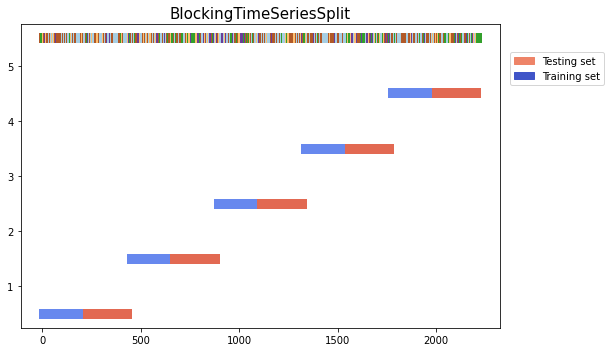

In [27]:
from matplotlib.patches import Patch

n_splits = 5
cv = BlockingTimeSeriesSplit
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=None)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)
        
    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class']
    # ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
    #        xlabel='Sample index', ylabel="CV iteration",
    #        ylim=[n_splits+1.2, -.1], xlim=[0, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax


def plot_timeseries_split(X,y):

        this_cv = cv(n_splits=n_splits)
        fig, ax = plt.subplots(figsize=(10, 5))
        plot_cv_indices(this_cv, X, y, ax, n_splits)

        ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
                ['Testing set', 'Training set'], loc=(1.02, .8))
        plt.tight_layout()
        fig.subplots_adjust(right=.7)
                
        plt.show()

print("The horizontal axis is the training set size while the vertical axis represents the cross-validation iterations. The folds used for training are depicted in blue and the folds used for validation are depicted in orange. The final horizontal bar are the FIVE [-2,-1,0,1,2] class labels for the response variable")
plot_timeseries_split(np.array(X_train_dict['Original']),np.array(y_train.Labels))


### Remove all constant Variables
<div style="color: Green; font-size:22px;" class="alert alert-block alert-warning"> 
<b>To Do:</b> Check why the following features have only one value
</div>

In [28]:
# Issue with using XGBOOST - takes long time and gives warnigs Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

warnings.filterwarnings("ignore")

dataset = 'Constant'
pipe = Pipeline([(dataset, DropConstantFeatures(tol=1, variables=None, missing_values='raise'))])
apply_pipe_transform(dataset,'Original', pipe, models[0])
# apply_pipe_transform(dataset,'Original', pipe, models[1])


Removing Features for dataset: Constant
# Features before: 762

Removed Features for Pipeline: Pipeline(steps=[('Constant', DropConstantFeatures())])
Constant : 46
Total removed: 46

Shapes for dataset: Constant
X_train Shape (2216, 716)
X_test Shape (555, 716)
X_val Shape (124, 716)


### Remove Quasi-constant features

In [29]:
dataset = 'QuasiConstant'
pipe = Pipeline([(dataset, DropConstantFeatures(tol=0.95, variables=None, missing_values='raise')),])
apply_pipe_transform(dataset,'Original', pipe, models[0])


Removing Features for dataset: QuasiConstant
# Features before: 762

Removed Features for Pipeline: Pipeline(steps=[('QuasiConstant', DropConstantFeatures(tol=0.95))])
QuasiConstant : 57
Total removed: 57

Shapes for dataset: QuasiConstant
X_train Shape (2216, 705)
X_test Shape (555, 705)
X_val Shape (124, 705)


### Remove Duplicated Features

In [30]:
dataset = 'Duplicated'
pipe = Pipeline([(dataset, DropDuplicateFeatures(variables=None, missing_values='raise')),])
apply_pipe_transform(dataset,'Original', pipe, models[0])


Removing Features for dataset: Duplicated
# Features before: 762

Removed Features for Pipeline: Pipeline(steps=[('Duplicated', DropDuplicateFeatures(missing_values='raise'))])
Duplicated : 85
Total removed: 85

Shapes for dataset: Duplicated
X_train Shape (2216, 677)
X_test Shape (555, 677)
X_val Shape (124, 677)


### Remove Duplicated & Quasi Constant Features

In [31]:
dataset = 'Dupl&QConstant'
pipe = Pipeline([(dataset, DropDuplicateFeatures(variables=None, missing_values='raise')),])
apply_pipe_transform(dataset,'QuasiConstant', pipe, models[0])


Removing Features for dataset: Dupl&QConstant
# Features before: 705

Removed Features for Pipeline: Pipeline(steps=[('Dupl&QConstant',
                 DropDuplicateFeatures(missing_values='raise'))])
Dupl&QConstant : 48
Total removed: 48

Shapes for dataset: Dupl&QConstant
X_train Shape (2216, 657)
X_test Shape (555, 657)
X_val Shape (124, 657)


### Remove Correlated Features

In [32]:
warnings.filterwarnings("ignore")

smart_correlation_estimator = models[0]
dataset = 'Correlated'
pipe = Pipeline([(dataset, SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.95,missing_values="raise",selection_method="variance",estimator=smart_correlation_estimator,scoring="roc_auc",cv=btscv,)),])
apply_pipe_transform(dataset,'Original', pipe, models[0])


Removing Features for dataset: Correlated
# Features before: 762

Removed Features for Pipeline: Pipeline(steps=[('Correlated',
                 SmartCorrelatedSelection(cv=<__main__.BlockingTimeSeriesSplit object at 0x000002192702F130>,
                                          estimator=RandomForestClassifier(max_depth=3,
                                                                           n_jobs=-1),
                                          method='spearman',
                                          missing_values='raise',
                                          selection_method='variance',
                                          threshold=0.95))])
Correlated : 257
Total removed: 257

Shapes for dataset: Correlated
X_train Shape (2216, 505)
X_test Shape (555, 505)
X_val Shape (124, 505)


### Remove Duplicated, Quasi Constant & Correlated Features

In [33]:
warnings.filterwarnings("ignore")
smart_correlation_estimator = models[0]
dataset = 'Clean'
pipe = Pipeline([(dataset, SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.95,missing_values="raise",selection_method="variance",estimator=smart_correlation_estimator,scoring="roc_auc",cv=btscv,)),])
apply_pipe_transform(dataset,'Dupl&QConstant', pipe, models[0])



Removing Features for dataset: Clean
# Features before: 657

Removed Features for Pipeline: Pipeline(steps=[('Clean',
                 SmartCorrelatedSelection(cv=<__main__.BlockingTimeSeriesSplit object at 0x000002192702F130>,
                                          estimator=RandomForestClassifier(max_depth=3,
                                                                           n_jobs=-1),
                                          method='spearman',
                                          missing_values='raise',
                                          selection_method='variance',
                                          threshold=0.95))])
Clean : 206
Total removed: 206

Shapes for dataset: Clean
X_train Shape (2216, 451)
X_test Shape (555, 451)
X_val Shape (124, 451)


### Clean1 - Drop constant, quasi Constant, duplicated and correlated features

In [34]:
warnings.filterwarnings("ignore")

smart_correlation_estimator = models[0]
dataset = 'Clean1'
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasiConstant', DropConstantFeatures(tol=0.95, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures(variables=None, missing_values='raise')),
    ('correlation', SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.95,missing_values="raise",selection_method="variance",estimator=smart_correlation_estimator,scoring="roc_auc",cv=btscv,)),])
apply_pipe_transform(dataset,'Original', pipe ,models[0])
apply_pipe_transform(dataset,'Original', pipe ,models[1])


Removing Features for dataset: Clean1
# Features before: 762

Removed Features for Pipeline: Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasiConstant', DropConstantFeatures(tol=0.95)),
                ('duplicated', DropDuplicateFeatures(missing_values='raise')),
                ('correlation',
                 SmartCorrelatedSelection(cv=<__main__.BlockingTimeSeriesSplit object at 0x000002192702F130>,
                                          estimator=RandomForestClassifier(max_depth=3,
                                                                           n_jobs=-1),
                                          method='spearman',
                                          missing_values='raise',
                                          selection_method='variance',
                                          threshold=0.95))])
constant : 46
quasiConstant : 11
duplicated : 48
correlation : 206
Total removed: 311

Shapes for dataset: Clean1
X_train Shape (2

In [35]:
features_df.drop(['Model_Details','Features_List','Removed_Features'],axis=1)

Num_Features balanced_accuracy  \
Model                  Dataset                                         
RandomForestClassifier Original                762              0.25   
XGBClassifier          Original                762              0.25   
RandomForestClassifier Constant                716              0.21   
                       QuasiConstant           705              0.24   
                       Duplicated              677              0.21   
                       Dupl&QConstant          657              0.26   
                       Correlated              505              0.19   
                       Clean                   451              0.25   
                       Clean1                  451              0.22   
XGBClassifier          Clean1                  451              0.25   

                                      precision_weighted recall_weighted  \
Model                  Dataset                                             
RandomForestClassifier Original                     0.43             0.3   
XGBClassifier          Original                     0.41            0.27   
RandomForestClassifier Constant                     0.44            0.34   
                       QuasiConstant                0.42            0.34   
                       Duplicated                   0.43            0.39   
                       Dupl&QConstant               0.48            0.38   
                       Correlated                   0.49            0.34   
                       Clean                        0.41            0.38   
                       Clean1                       0.51            0.41   
XGBClassifier          Clean1                       0.27            0.32   

                                      f1_weighted roc_auc_ovr_weighted  \
Model                  Dataset                                           
RandomForestClassifier Original               0.4                  NaN   
XGBClassifier          Original              0.29                  NaN   
RandomForestClassifier Constant               0.3                  NaN   
                       QuasiConstant          0.3                  NaN   
                       Duplicated            0.35                  NaN   
                       Dupl&QConstant        0.37                  NaN   
                       Correlated            0.39                  NaN   
                       Clean                 0.37                  NaN   
                       Clean1                0.41                  NaN   
XGBClassifier          Clean1                0.27                  NaN   

                                      roc_auc_ovo_weighted  
Model                  Dataset                              
RandomForestClassifier Original                        NaN  
XGBClassifier          Original                        NaN  
RandomForestClassifier Constant                        NaN  
                       QuasiConstant                   NaN  
                       Duplicated                      NaN  
                       Dupl&QConstant                  NaN  
                       Correlated                      NaN  
                       Clean                           NaN  
                       Clean1                          NaN  
XGBClassifier          Clean1                          NaN

**

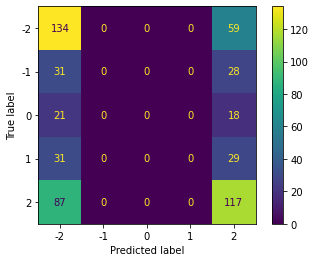

In [36]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
rf.fit(X_train_dict['Clean1'], y_train.Labels)
plot_confusion_matrix(rf, X_test_dict['Clean1'], y_test.Labels)

In [37]:
# Fitting the model here since it takes > 1 min
rf = RandomForestClassifier(n_estimators=200, max_depth=3, n_jobs=-1)
xgb = XGBClassifier(n_estimators=200, max_depth=3, n_jobs=-1,eval_metric='mlogloss')
lab = Response.Labels.unique()
lab.sort()
xgb.fit(X_train_dict['Clean1'], y_train.Labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [38]:

y_pred = xgb.predict(X_test_dict['Clean1'])
df1 = pd.DataFrame(np.transpose(precision_recall_fscore_support(y_test.Labels, y_pred, average=None)),columns=['precision', 'recall', 'fscore', 'support'], index=lab)
# df1 = pd.DataFrame(np.transpose(precision_recall_fscore_support(y_test.Labels, y_pred, average='macro')),index = ['precision', 'recall', 'fscore', 'support'])
df1

precision_recall_fscore_support(y_test.Labels, y_pred, average='weighted')



(0.4053294748974423, 0.3981981981981982, 0.3969526028621697, None)

### 
    1. Recall/Sensitivity/TPR: tp / (tp + fn) - **%age of a TRUE/Positives class correctly identified/ ability to find all the positive samples**
    2. Specificity (TNR) is tn / (tn + fp) - %age of a FALSE/Negatives class correctly identified
    3. False Positive Rate (FPR) = 1 - Specificity or fp / (tn + fp)
    4. Accuracy is TP/ entire matrix sum ???
    5. Precision is tp / (tp + fp) - the ability not to label a negative sample as positive.
    6. Support is the number of occurrences of each class  - sum of respective row
    7. Macro - unweighted mean. This does not take label imbalance into account.
    8. Wt_Avg - average weighted by support

**True/False (Positives/Negatives) means if a sample belongs/doesn't belong to a class**


In [39]:
generate_sample_confusion_matrix(-2)

In [72]:

from sklearn.model_selection import cross_val_predict


model = models[0]
model.fit(X_train_dict['Clean1'], y_train.Labels)
y_pred = model.predict(X_test_dict['Clean1'])

# y_pred = cross_val_score(model, X_train_dict['Clean1'], y_train.Labels, cv=5)
y_pred


array([-2, -2, -2, -2, -2, -2,  2, -2,  2, -2,  2, -2,  2,  2,  2,  2,  2,
        2,  2, -2, -2, -2, -2, -2, -2,  2, -2, -2, -2,  2, -2,  2,  2,  2,
        2,  2,  2,  2, -2,  2, -2, -2, -2, -2,  2,  2, -2,  2, -2,  2, -2,
       -2, -2,  2,  2,  2,  2,  2,  2,  2, -2, -2,  2, -2, -2, -2, -2, -2,
       -2, -2, -2, -2,  2,  2,  2, -2,  2, -2, -2, -2, -2, -2,  2, -2, -2,
        2,  2, -2, -2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, -2, -2,
       -2, -2, -2, -2, -2, -2,  2,  2,  2,  2,  2,  2,  2,  2,  2, -2, -2,
       -2, -2, -2, -2,  2, -2, -2,  2, -2, -2, -2, -2, -2, -2,  2,  2, -2,
       -2,  2,  2,  2,  2, -2, -2,  2,  2,  2,  2,  2, -2, -2, -2, -2, -2,
       -2, -2, -2, -2, -2,  2,  2,  2, -2,  2, -2,  2, -2, -2, -2, -2, -2,
       -2, -2,  2,  2, -2,  2, -2, -2, -2,  2, -2,  2, -2,  2,  2, -2, -2,
        2,  2,  2, -2,  2,  2,  2, -2, -2, -2,  2, -2, -2, -2, -2,  2,  2,
        2,  2, -2, -2,  2

In [73]:
y_pred.shape

(555,)

In [74]:
y_train.Labels.shape

(2216,)

In [42]:
# Fitting the model here since takes ~ 1.30 minute
# model = models[1]
# model.fit(X_train_dict['Clean1'], y_train.Labels)
# y_pred = model.predict(X_test_dict['Clean1'])

In [75]:

lab = Response.Labels.unique()
lab.sort()

cm = pd.DataFrame(confusion_matrix(y_test.Labels, y_pred))
cm.index = lab
cm.columns = lab
df = pd.DataFrame()
pre = {}
rec = {}
tp = {}
tn = {}
fp = {}
fn = {}
weighted_average = {}
for cat in lab:
    pre[cat] = np.nan_to_num(cm.loc[cat,cat]/cm.sum(axis=0).loc[cat], nan=0.0, posinf=0.0, neginf=0.0)
    rec[cat] = np.nan_to_num(cm.loc[cat,cat]/cm.sum(axis=1).loc[cat], nan=0.0, posinf=0.0, neginf=0.0)
    tp[cat] = cm.loc[cat, cat]
    tn[cat] = cm.drop(cat,axis=1).drop(cat,axis=0).sum().sum()
    fp[cat] = cm[cat].drop(cat).sum()
    fn[cat] = cm.loc[cat].drop(cat).sum()

df = pd.concat([pd.DataFrame.from_dict(pre,orient='index', columns=['precision']),pd.DataFrame.from_dict(rec,orient='index', columns=['recall'])], axis=1)
df['fscore'] = (2 * (df.precision * df.recall) / (df.precision + df.recall)).fillna(0)
df['tp'] = pd.Series(tp)
df['tn'] = pd.Series(tn)
df['fp'] = pd.Series(fp)
df['fn'] = pd.Series(fn)

df['specificity'] =  pd.Series(df.tn / (df.tn + df.fp))
df['fpr'] = pd.Series(df.fp / (df.tn + df.fp))
df['accuracy'] = (df.tp) / (df.tp + df.tn + df.fp + df.fn)
df['support'] = cm.sum(axis=1)

main_metrics_list = ['precision', 'recall', 'fscore', 'specificity','fpr', 'accuracy']
df_perc = df[main_metrics_list]
df = pd.concat([df_perc,df.tp,df.tn,df.fp,df.fn,df.support], axis=1)

df.loc['macro'] = df.mean()

# Weighted average
for cols in df.columns:
    if cols in main_metrics_list:
        weighted_average[cols] = df[cols].dot(df.support)/df.support.sum()
    else:
        weighted_average[cols] = None

weight_df = pd.DataFrame.from_dict(weighted_average,orient='index', columns=['Wt_Avg']).T
df = pd.concat([df, weight_df], axis=0)

# % Formatting
for col in main_metrics_list:
    try:
        df[col] = df[col].mul(100).round(0).astype(int).astype(str).add('%')
    except:
        pass

df

,precision,recall,fscore,specificity,fpr,accuracy,tp,tn,fp,fn,support
-2,44%,65%,52%,56%,44%,23%,125.0,202.0,160.0,68.0,193.0
-1,0%,0%,0%,100%,0%,0%,0.0,496.0,0.0,59.0,59.0
0,0%,0%,0%,100%,0%,0%,0.0,516.0,0.0,39.0,39.0
1,0%,0%,0%,100%,0%,0%,0.0,495.0,0.0,60.0,60.0
2,47%,62%,54%,59%,41%,23%,127.0,208.0,143.0,77.0,204.0
macro,18%,25%,21%,83%,17%,9%,50.4,383.4,60.6,60.6,111.0
Wt_Avg,30%,42%,35%,72%,28%,15%,NaN,NaN,NaN,NaN,NaN


In [44]:
features_df.drop(['Model_Details','Features_List','Removed_Features'],axis=1)

Num_Features balanced_accuracy  \
Model                  Dataset                                         
RandomForestClassifier Original                762              0.25   
XGBClassifier          Original                762              0.25   
RandomForestClassifier Constant                716              0.21   
                       QuasiConstant           705              0.24   
                       Duplicated              677              0.21   
                       Dupl&QConstant          657              0.26   
                       Correlated              505              0.19   
                       Clean                   451              0.25   
                       Clean1                  451              0.22   
XGBClassifier          Clean1                  451              0.25   

                                      precision_weighted recall_weighted  \
Model                  Dataset                                             
RandomForestClassifier Original                     0.43             0.3   
XGBClassifier          Original                     0.41            0.27   
RandomForestClassifier Constant                     0.44            0.34   
                       QuasiConstant                0.42            0.34   
                       Duplicated                   0.43            0.39   
                       Dupl&QConstant               0.48            0.38   
                       Correlated                   0.49            0.34   
                       Clean                        0.41            0.38   
                       Clean1                       0.51            0.41   
XGBClassifier          Clean1                       0.27            0.32   

                                      f1_weighted roc_auc_ovr_weighted  \
Model                  Dataset                                           
RandomForestClassifier Original               0.4                  NaN   
XGBClassifier          Original              0.29                  NaN   
RandomForestClassifier Constant               0.3                  NaN   
                       QuasiConstant          0.3                  NaN   
                       Duplicated            0.35                  NaN   
                       Dupl&QConstant        0.37                  NaN   
                       Correlated            0.39                  NaN   
                       Clean                 0.37                  NaN   
                       Clean1                0.41                  NaN   
XGBClassifier          Clean1                0.27                  NaN   

                                      roc_auc_ovo_weighted  
Model                  Dataset                              
RandomForestClassifier Original                        NaN  
XGBClassifier          Original                        NaN  
RandomForestClassifier Constant                        NaN  
                       QuasiConstant                   NaN  
                       Duplicated                      NaN  
                       Dupl&QConstant                  NaN  
                       Correlated                      NaN  
                       Clean                           NaN  
                       Clean1                          NaN  
XGBClassifier          Clean1                          NaN

In [ ]:
precision_recall_fscore_support(y_test.Labels, y_pred, average='macro')

In [ ]:
df.fscore.dot(df.support)/df.support.sum()

In [ ]:
plot_confusion_matrix(model, X_test_dict['Clean1'], y_test.Labels);

In [ ]:
# Insert the dataframe in a cell in features_df
features_df['to_delete'] = None
features_df['to_delete'].astype(object)
features_df.loc[('RandomForestClassifier','Original'),'to_delete'] =  [df]
features_df.loc[('RandomForestClassifier','Original'),'to_delete'][0]

In [ ]:
# weighted averaged
# for col in df.columns[:-1]:
#     print(df[col].values.dot(df.support)/df.support.sum())

In [ ]:
print(classification_report(y_test.Labels, y_pred))

In [ ]:
# xgb = XGBClassifier(n_estimators=200, max_depth=3, n_jobs=-1)
# rf.fit(X_train_dict['Clean1'], y_train.Labels, eval_metric='mlogloss')
# rf.fit(X_train_dict['Clean1'], y_train.Labels)
# plot_confusion_matrix(rf, X_test_dict['Clean1'], y_test.Labels,);

In [ ]:
# import xgboost as xgb
# xgb_m = xgb.XGBClassifier(n_estimators=200, max_depth=3, n_jobs=-1)
# rf = RandomForestClassifier(n_estimators=200, max_depth=3, n_jobs=-1)

# xgb_m.fit(X_train_dict['Clean1'], y_train.Labels)
# rf.fit(X_train_dict['Clean1'], y_train.Labels)
# y_pred = rf.predict(X_test_dict['Clean1'])



In [ ]:
y_val.Labels.value_counts()

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test.Labels, y_pred)
print(confusion_matrix)


In [ ]:
STOP HERE

****TO USE***

In [ ]:
fpr_, fnr_, thresholds_ = det_curve(y_test.Close_Up_Down, y_pred)
model.fit(X_train_dict['Original'], y_train.Close_Up_Down)
y_prob = model.predict_proba(X_test_dict['Original'])
y_pred = model.predict(X_test_dict['Original'])

y_pred = (clf.predict_proba(X_test_dict['Original'])[:,1] >= p).astype(bool) # set threshold as 0.3
fpr, tpr, threshold = roc_curve(y_test.Close_Up_Down, y_pred,)


model = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
model.fit(X_train_dict['Clean'], y_train.Close_Up_Down)
y_pred = model.predict(X_test_dict['Clean'])
confusion_matrix(y_test.Close_Up_Down, y_pred)
plot_confusion_matrix(clf, X_test_dict['Clean'], y_test.Close_Up_Down,);
clsf_report = classification_report(y_test.Close_Up_Down, y_pred, output_dict=True)
pd.DataFrame(clsf_report)

### Univariate Selection Methods - Mostly just examine linear relationships

#### Mutual Information

In [ ]:
mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False, inplace = True)

# Plot
# mi.plot.bar(figsize=(20, 6))
# plt.ylabel('Mutual Information')

# select features
sel_ = SelectKBest(mutual_info_classif, k=15).fit(X_train, y_train)

# display features
X_train.columns[sel_.get_support()]

#### Chi-square Statistic - only suited for classification!                                         
https://www.udemy.com/course/feature-selection-for-machine-learning/learn/lecture/22495182#questions
https://github.com/solegalli/feature-selection-for-machine-learning/blob/main/05-Filter-Statistical-Tests/05.2-Fisher-score.ipynb

In [ ]:
# calculate the chi2 p_value between each of the variables and the target
# chi2 returns 2 arrays, one contains the F-Scores which are then evaluated against the chi2 distribution to obtain the pvalue. The pvalues are in the second array

# Input X must be non-negative
X_train_non_negative = X_train[X_train.columns[((X_train < 0).sum(axis=0) == 0).values]]
f_score = chi2(X_train_non_negative.fillna(0), y_train)
pvalues = pd.Series(f_score[1])
pvalues.index = X_train_non_negative.columns
pvalues.sort_values(ascending=True, inplace = True)
extremely_low_p_values = len(pvalues[pvalues < 1e-100])
sel_ = SelectKBest(chi2, k= extremely_low_p_values).fit(X_train_non_negative, y_train)
X_train_non_negative.columns[sel_.get_support()] # display features

# X_train = sel_.transform(X_train)
# X_test = sel_.transform(X_test)

#### Anova - tests 2 samples have same mean

Assumptions:
Sample are independant & normally distributed, homegeneity of variance

In [ ]:
# calculate the univariate statistical measure between each of the variables and the target
# similarly to chi2, the output is one array with f-scores and one array with the pvalues

univariate = f_classif(X_train, y_train)
univariate = pd.Series(univariate[1])
univariate.index = X_train.columns
univariate.sort_values(ascending=True, inplace = True) # The smaller the p_value the more predictive the feature is

pvalue_above_5_percent = len(univariate[univariate < 0.05])
sel_ = SelectKBest(f_classif, k=pvalue_above_5_percent).fit(X_train, y_train)
features_to_keep = sel_.get_feature_names_out()
features_to_keep

# select features
# X_train_anova = sel_.transform(X_train)
# X_test_anova = sel_.transform(X_test)

# # numpy array to dataframe
# X_train_anova = pd.DataFrame(X_train_anova)
# X_train_anova.columns = features_to_keep

# X_test_anova = pd.DataFrame(X_test_anova)
# X_test_anova.columns = features_to_keep

# X_train_anova.shape, X_test_anova.shape



### Wrapper Methods

### Embedded Methods | Tree Importance

In [ ]:
# Selects features whose importance is greater than the threshold. - Thershold is the mean importance of all features
sel_ = SelectFromModel(RandomForestClassifier(n_estimators=300,  max_depth=3, n_jobs=-1)).fit(X_train, y_train)
selected_features = X_train.columns[sel_.get_support()]
print(len(selected_features))
TopNFeatures = pd.DataFrame(index = sel_.estimator_.feature_names_in_.tolist(),data = sel_.estimator_.feature_importances_, columns = ['Imp']).sort_values(by='Imp',ascending=False).head(20).index.tolist()
pd.Series(sel_.estimator_.feature_importances_.ravel()).hist(bins=20);

In [ ]:
TopNFeatures

### Embedded Methods | Tree Importance Recursively

In [ ]:
# Takes 1:44 mins to run
sel_ = RFE(RandomForestClassifier(n_estimators=100,  max_depth=3, n_jobs=-1), n_features_to_select=30).fit(X_train, y_train)
selected_features = X_train.columns[sel_.get_support()]
print(len(selected_features))
selected_features


In [ ]:
rf = RandomForestClassifier(n_estimators=200, max_depth=3, n_jobs=-1)
rf.fit(X_train[selected_features].fillna(0), y_train)
y_pred = rf.predict(X_test[selected_features].fillna(0))
y_valid_pred = rf.predict(X_val[selected_features].fillna(0))
print("Test Accuracy:", accuracy_score(y_test.fillna(0), y_pred))
print("Validation Accuracy:", accuracy_score(y_val.fillna(0), y_valid_pred))


In [ ]:
print('Train set')
pred = rf.predict_proba(X_train[selected_features])
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

print('Test set')
pred = rf.predict_proba(X_test[selected_features])
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

print('Validation set')
pred = rf.predict_proba(X_val[selected_features])
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_val, pred[:, 1])))

### Feature Selection by Random Shuffling

In [ ]:
# Takes 1 min to run - You can use this procedure with any machine learning algorithm

rf = RandomForestClassifier(n_estimators=50, max_depth=2, n_jobs=-1)

sel = SelectByShuffling(
    variables=None, # automatically examine all numerical variables
    estimator=rf, # the ML model
    scoring='roc_auc', # the metric to evaluate
    threshold=0,# the maximum performance drop allowed to select the feature
    cv=btscv, # cross validation
)

sel.fit(X_train, y_train)


In [ ]:
sel.initial_model_performance_ # performance of model trained with all features

In [ ]:
# pd.Series(sel.performance_drifts_).sort_values(ascending=False).plot.bar(figsize=(16,6));

In [ ]:
# features that will be removed

print(len(sel.features_to_drop_))
# remove features

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)
X_val = sel.transform(X_val)

X_train.shape, X_test.shape

In [ ]:
rf.fit(X_train, y_train)
print( 'train auc score: ',roc_auc_score(y_train, (rf.predict_proba(X_train))[:,1]))
print('test auc score: ', roc_auc_score(y_test, (rf.predict_proba(X_test))[:, 1]))
print('Validation auc score: ', roc_auc_score(y_val, (rf.predict_proba(X_val))[:, 1]))

In [ ]:
X_train.columns

### Recursive Feature Elimination

In [ ]:
model = GradientBoostingClassifier(
    n_estimators=10,
    max_depth=2,
    random_state=10,
)

In [ ]:
# NOT WORKING

sel = RecursiveFeatureElimination(
    variables=None, # automatically evaluate all numerical variables
    estimator = model, # the ML model
    scoring = 'roc_auc', # the metric we want to evalute
    threshold = 0.0005, # the maximum performance drop allowed to remove a feature
    cv=btscv, # cross-validation
)

# this may take quite a while, because
# we are building a lot of models with cross-validation
# sel.fit(X_train, y_train)

In [ ]:
sel.initial_model_performance_

In [ ]:
# performance of model trained using all features
sel.initial_model_performance_

In [ ]:
# importance of all features based of initial model
sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

In [ ]:
# Number of features that will be removed

len(sel.features_to_drop_)

### Random Forest

In [ ]:
features = list(X_train.columns)
rf = RandomForestClassifier(n_estimators=200, max_depth=3)
rf.fit(X_train[features].fillna(0), y_train)

importance = pd.concat([pd.Series(features),pd.Series(rf.feature_importances_)], axis=1)
importance.columns = ['feature', 'importance']
importance.sort_values(by=['importance'], ascending=False, inplace=True)
y_pred = rf.predict(X_test[features].fillna(0))
y_valid_pred = rf.predict(X_val[features].fillna(0))

print("Test Accuracy:", accuracy_score(y_test.fillna(0), y_pred))
print("Validation Accuracy:", accuracy_score(y_val .fillna(0), y_valid_pred))

### Compare the performance in machine learning algorithms

In [ ]:
X_train_basic_filter.shape, X_test_basic_filter.shape, X_train.shape, X_test.shape

In [ ]:

def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(n_estimators=300,  max_depth=3, n_jobs=-1)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

In [ ]:
# filter methods - basic
run_randomForests(X_train_basic_filter,X_test_basic_filter,y_train, y_test)

In [ ]:
# Final model
run_randomForests(X_train, X_test, y_train, y_test)

### Logistic Regression

In [ ]:
# create a function to build logistic regression and compare performance in train and test set

from sklearn.metrics import confusion_matrix

def run_logistic(X_train, X_test, y_train, y_test):
    
    # function to train and test the performance of logistic regression
    logit = LogisticRegression(penalty='l1', random_state=44, max_iter=1000, solver='liblinear')
    logit.fit(X_train, y_train)
    print('Train set')
    pred = logit.predict_proba(X_train)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = logit.predict_proba(X_test)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

scaler = StandardScaler().fit(X_train)

run_logistic(scaler.transform(X_train),
             scaler.transform(X_test),
                  y_train, y_test)

### 
<div style="color: DarkBlue; font-size:22px;" class="alert alert-block alert-warning"> 
<b>Pipelines:</b> Final Code will look like this but for now work through issues above 
</div>

In [ ]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasiConstant', DropConstantFeatures(tol=0.9, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures(variables=None, missing_values='raise')),
    ('correlation', SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.9,missing_values="raise",selection_method="variance",estimator=rf,scoring="roc_auc",cv=btscv,)),])


pipe.fit(X_train)

# remove features
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)
X_val = pipe.transform(X_val)

X_train.shape, X_test.shape, X_val.shape


In [ ]:
print(len(pipe.named_steps['constant'].features_to_drop_))
pipe.named_steps['duplicated'].features_to_drop_

# NOT USING - for reference

### Correlated Features - Brute Force approach

In [ ]:
def correlation(dataset, threshold):
    
    col_corr = set()
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        
        for j in range(i):
            
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
             
                print(abs(corr_matrix.iloc[i, j]),":", corr_matrix.columns[i], "<< - >>", corr_matrix.columns[j])
                colname = corr_matrix.columns[j]
                
                # and add it to our correlated set
                col_corr.add(colname)
                
    return col_corr

# corr_features = correlation(X_train, 0.9)
# len(set(corr_features))


In [ ]:
# corr_features = correlation(X_train, 0.9)

### Correlated Features - Second Approach

In [ ]:
corrmat = X_train.corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.9]
corrmat = corrmat[corrmat < 1] # Not Interested in the correlation with 1 since will be with the same variable
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

In [ ]:
grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]

        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train.shape[1]))



In [ ]:
# for group in correlated_groups:
#     print(group)
#     print()

In [ ]:
#Choose Group Index
group_index = 1

group = correlated_groups[group_index]
var = group.feature1.unique()[0]

# add all features of the group to a list
features = list(group['feature2'].unique())+[var]

rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
rf.fit(X_train[features].fillna(0), y_train)

importance = pd.concat([pd.Series(features),pd.Series(rf.feature_importances_)], axis=1)
importance.columns = ['feature', 'importance']

print(var)
importance.sort_values(by='importance', ascending=False)


In [ ]:
# for feature in group['feature2']:
#     plt.scatter(X_train[var], X_train[feature])
#     plt.xlabel(feature)
#     plt.ylabel(var)
#     plt.show()

### Just an example to show one group of how smart correlation works

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")

group = sel.correlated_feature_sets_[0]

# build random forest with cross validation for each feature
for f in group:
    
    model = cross_validate(
        rf,
        X_train[f].to_frame(),
        y_train,
        cv=btscv,
        return_estimator=False,
        scoring='accuracy',
    )

#  scoring='roc_auc' does not support categorical data.

    print(f, model["test_score"].mean())

****TO USE***

In [ ]:
fpr_, fnr_, thresholds_ = det_curve(y_test.Close_Up_Down, y_pred)
model.fit(X_train_dict['Original'], y_train.Close_Up_Down)
y_prob = model.predict_proba(X_test_dict['Original'])
y_pred = model.predict(X_test_dict['Original'])

y_pred = (clf.predict_proba(X_test_dict['Original'])[:,1] >= p).astype(bool) # set threshold as 0.3
fpr, tpr, threshold = roc_curve(y_test.Close_Up_Down, y_pred,)


model = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
model.fit(X_train_dict['Clean'], y_train.Close_Up_Down)
y_pred = model.predict(X_test_dict['Clean'])
confusion_matrix(y_test.Close_Up_Down, y_pred)
plot_confusion_matrix(clf, X_test_dict['Clean'], y_test.Close_Up_Down,);
clsf_report = classification_report(y_test.Close_Up_Down, y_pred, output_dict=True)
pd.DataFrame(clsf_report)

### Classification Model Evaluation metrics
1. cross_val_score
2. Area under the ROC Curve
3. Confusion Matrix
4. Confusion Report

https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics


In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
cross_val_score(model, Variables, Response.Close_Up_Down, cv = 2, scoring = 'accuracy')

In [ ]:
model = RandomForestClassifier(n_estimators=300, max_depth=10, n_jobs=-1)
cross_val_score(model, X_train_dict['Original'], y_train.Labels, cv = 5,scoring='roc_auc_ovo_weighted')

In [ ]:
model = RandomForestClassifier(n_estimators=300, max_depth=10, n_jobs=-1)
cross_val_score(model, X_train_dict['Clean1'], y_train.Labels, cv = 5,scoring='roc_auc_ovo')

In [ ]:
model.fit(X_train_dict['Original'], y_train.Close_Up_Down)
y_prob = model.predict_proba(X_test_dict['Original'])
y_pred = model.predict(X_test_dict['Original'])


In [ ]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
clf.fit(X_train_dict['Original'], y_train.Close_Up_Down)

for p in [0.475,0.5,0.525]:
    
    y_pred = (clf.predict_proba(X_test_dict['Original'])[:,1] >= p).astype(bool) # set threshold as 0.3
    fpr, tpr, threshold = roc_curve(y_test.Close_Up_Down, y_pred,)
    print("tpr:",tpr)
    print("fpr:",fpr)
    print("threshold:",threshold)
    print(p,": ",roc_auc_score(y_test.Close_Up_Down, y_pred))
    print("\n")

https://stackoverflow.com/questions/45715018/scikit-learn-how-to-plot-probabilities

In [ ]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
clf.fit(X_train_dict['Clean'], y_train.Close_Up_Down)
plt.figure(figsize=(12,5))
prediction = clf.predict_proba(X_test_dict['Clean'])[:,1]
plt.hist(prediction[y_test.Close_Up_Down==-1], bins=100, label='Negatives')
plt.hist(prediction[y_test.Close_Up_Down==1], bins=100, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=10)
plt.ylabel('Number of records in each bucket', fontsize=10)
# plt.xlim(0,1)
plt.legend(fontsize=10)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()

In [ ]:
def plot_roc_auc_curve(y_test, model_set, model):
    model.fit(X_train_dict[model_set], y_train.Close_Up_Down)
    y_prob_positive = model.predict_proba(X_test_dict[model_set])[:,1]
    print(f"ROC_AUC_SCORE: {roc_auc_score(y_test.Close_Up_Down, y_prob_positive):.2f}%")
    fpr, tpr, threshold = roc_curve(y_test.Close_Up_Down, y_prob_positive,)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

model = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)

plot_roc_auc_curve(y_test, 'Original', model)
# plot_roc_auc_curve(y_test, 'Original', y_test)

In [ ]:
(y_pred == [-1 if x[0] > 0.5 else 1 for x in y_prob]).all()

In [ ]:
# Took 5:20 mins
# from sklearn.ensemble import GradientBoostingClassifier
# model = GradientBoostingClassifier(n_estimators=100, max_depth=3)
# cross_val_score(model, Variables, Response.Close_Up_Down, cv = 5).min()

**Confusion Matrix**

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
model.fit(X_train_dict['Clean'], y_train.Close_Up_Down)
y_pred = model.predict(X_test_dict['Clean'])
confusion_matrix(y_test.Close_Up_Down, y_pred)

In [ ]:
pd.crosstab(y_test.Close_Up_Down, y_pred, rownames=['Actual'], colnames=['Predicted'])

In [ ]:
import seaborn as sns

conf_mat = confusion_matrix(y_test.Close_Up_Down, y_pred)
sns.heatmap(pd.crosstab(y_test.Close_Up_Down, y_pred, rownames=['Actual'], colnames=['Predicted']), annot=True)

In [ ]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(8,5))

ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues');
plt.xlabel('Actual');
plt.ylabel('Predicted');




In [ ]:
plot_confusion_matrix(clf, X_test_dict['Clean'], y_test.Close_Up_Down,);

In [ ]:
plot_confusion_matrix(clf, X_val_dict['Clean'], y_val.Close_Up_Down,);

**Clasification Report**

In [ ]:
clsf_report = classification_report(y_test.Close_Up_Down, y_pred, output_dict=True)
pd.DataFrame(clsf_report)

In [ ]:
fpr

In [ ]:
print(classification_report(y_test.Close_Up_Down, y_pred))

In [ ]:
clsf_report['-1.0']['f1-score']

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, det_curve
precision_score(y_test.Close_Up_Down, y_pred)

In [ ]:
fpr_, fnr_, thresholds_ = det_curve(y_test.Close_Up_Down, y_pred)

In [ ]:
fpr_

In [ ]:
fnr_

In [ ]:
thresholds_